# 00 Install Dependecies

In [ ]:
!pip install cv2

In [ ]:
!pip install numpy

In [ ]:
!pip install pandas

In [1]:
# For image processing
import cv2
import imutils
import numpy as np
import pandas as pd

# For Math
import math
from scipy.stats import norm

# For path
import os
from pathlib import Path

# For displaying
from PIL import Image
from IPython.display import display

# For performance
import time
from multiprocessing import Pool, cpu_count

In [2]:
from util_db import search_deck, search_card
from match_scale import match_scale_mp
from match_card import match_card
from util_trim import trans_raw, trans_dup, trans_group, trans_sort, trans_name, trans_type, trans_paste

In [3]:
cwd = Path.cwd()
dir_main = Path.cwd().parent
n_cpu = cpu_count()

In [4]:
# def round_near(x):
#     integer_part = int(x)
#     fractional_part = x - integer_part
#     if fractional_part >= 0.5:
#         return integer_part + 1
#     else:
#         return integer_part

def round_near(x):
    x_f = math.floor(x)
    x_c = math.ceil(x)
    d_f = (x - x_f)
    d_c = (x_c - x)
    x = x_f if d_f < d_c else x_c
    return x

In [5]:
dir_full_db = f'{dir_main}/Data/YGO DB - export_full_db.csv'
df = pd.read_csv(dir_full_db)
df['Staple'].fillna('전용')
def fill_na_with_code(df):
    df['Staple'].fillna('전용')
    for col in df.columns:
        if col != 'Code' and df[col].isnull().any():
            df[col].fillna(df['Code'], inplace=True)
    return df
fill_na_with_code(df)
mean = df['Usage'].mean()
std = df['Usage'].std()
stdev = df['Usage'].apply(lambda x: round(norm.cdf(x, mean, std),2))
df['SD'] = stdev

In [6]:
df

,Code,Digit,Name_EN,Name_KO,Name_JA,Name_JA_Ruby,Reg,Type,Typo,Pendulum,Staple,Arch,Usage,Possible,SD
0,4007,89631139,Blue-Eyes White Dragon,푸른 눈의 백룡,青眼の白龍,ブルーアイズ・ホワイト・ドラゴン,4007,메인,일반,False,전용,백룡,10,True,0.47
1,4007,89631140,Blue-Eyes White Dragon,푸른 눈의 백룡,青眼の白龍,ブルーアイズ・ホワイト・ドラゴン,4007,메인,일반,False,전용,백룡,10,True,0.47
2,4007,89631141,Blue-Eyes White Dragon,푸른 눈의 백룡,青眼の白龍,ブルーアイズ・ホワイト・ドラゴン,4007,메인,일반,False,전용,백룡,10,True,0.47
3,4007,89631142,Blue-Eyes White Dragon,푸른 눈의 백룡,青眼の白龍,ブルーアイズ・ホワイト・ドラゴン,4007,메인,일반,False,전용,백룡,10,True,0.47
4,4007,89631143,Blue-Eyes White Dragon,푸른 눈의 백룡,青眼の白龍,ブルーアイズ・ホワイト・ドラゴン,4007,메인,일반,False,전용,백룡,10,True,0.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12308,18457,96305350,Gold Pride - Captain Carrie,18457,18457,18457,18457,메인,효과,False,전용,Gold Pride,0,False,0.46
12309,18458,22390469,Gold Pride - Star Leon,18458,18458,18458,18458,메인,효과,False,전용,Gold Pride,0,False,0.46
12310,18459,58884063,Gold Pride - Nytro Blaster,18459,18459,18459,18459,메인,효과,False,전용,Gold Pride,0,False,0.46
12311,18460,95283172,Gold Pride - The Crowd Goes Wild!,18460,18460,18460,18460,메인,효과,False,전용,Gold Pride,0,False,0.46


In [7]:
db_code = np.asanyarray(df["Code"])
db_digit = np.asarray(df["Digit"])
db_name_ko = np.asarray(df["Name_KO"])
db_type = np.asarray(df['Type'])

In [8]:
ind_hf = df.loc[(df['Staple'] == '범용'), 'Usage'].nlargest(25).index
db_code_freq = db_code[ind_hf]
db_digit_freq = db_digit[ind_hf]
db_name_freq = db_name_ko[ind_hf]

In [9]:
print(db_name_freq)

['증식의 G' '하루 우라라' '하루 우라라' '무한포영' '무덤의 지명자' '원시생명체 니비루' '라이트닝 스톰'
 '졸부와 겸허의 항아리' '길항승부' '드롤 & 로크 버드' '드롤 & 로크 버드' '말살의 지명자' '신의 심판' '해피의 깃털'
 '해피의 깃털' '네가로기어 아제우스' '이펙트 뵐러' '금지된 일적' '삼전의 재' '트윈트위스터' '코즈믹 싸이크론'
 '아티팩트－롱기누스' '스프라이트 엘프' '차원 장벽' '명왕결계파']


In [10]:
# Sample to Test For
card_list_freq = [
    "증식의 G","하루 우라라", "무덤의 지명자", "무한포영",
    "졸부와 겸허의 항아리", "말살의 지명자", "이펙트 뵐러", "삼전의 재",
    "금지된 일적", "어리석은 매장", "테라포밍", "원시생명체 니비루",
    "네가로기어 아제우스", "액세스코드 토커", "소명의 신궁－아폴로우사", "라이트닝 스톰",
    "길항승부", "드롤 & 로크 버드", "해피의 깃털", "신의 심판",
    "트윈트위스터", "코즈믹 싸이크론", "아티팩트－롱기누스", "차원 장벽",
    "레드 리부트", "명왕결계파", "부유벚꽃", "다이너레슬러 판크라톱스",]

In [11]:
dir_card_list_freq = []

for digit in db_digit_freq:
    dir_card = f'{dir_main}/YGO_DB/{digit}.jpg'
    dir_card_list_freq.append(dir_card)

img_card_list_freq = []
for dir_card in dir_card_list_freq:
    img_card = cv2.imread(dir_card, 0)
    img_card_list_freq.append(img_card)

In [12]:
db_digit_min = df.loc[df['Usage'] > 0, 'Digit'].tolist()
db_digit_avr = df.loc[df['Possible'], 'Digit'].tolist()
db_digit_max = df.loc[(df['Code'] > 0) & (df['Digit'] > 0), 'Digit'].tolist()

# 00 Preview Data

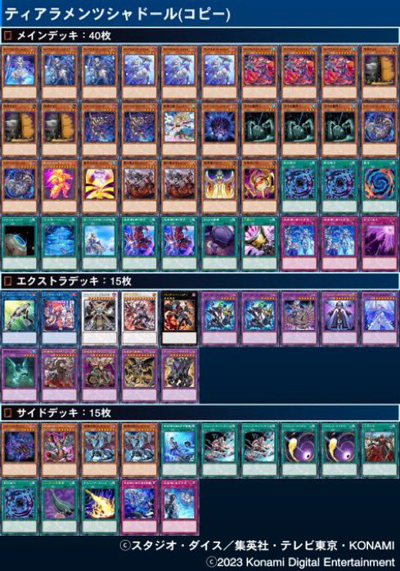

In [13]:
# Find deck path by deck_code
deck_code = '1354-003' 
dir_deck = search_deck(deck_code)
#######################################################
image = Image.open(dir_deck)
o_size = image.size
f = 400
width, height = f, int(f*o_size[1]/o_size[0])
image = image.resize((width, height))
display(image)

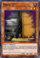

In [14]:
card_name = "증식의 G"
digit = search_card(card_name)
dir_card = f'{dir_main}/YGO_DB/{digit}.jpg'
#######################################################
image=Image.open(dir_card)
o_size = image.size
f = 40
width, height = f, int(f*o_size[1]/o_size[0])
image = image.resize((width, height))
display(image)

# 01 Using Snap shot

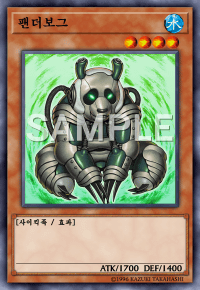

In [15]:
dir_snap_shot = f'{dir_main}/Data/snap_shot.jpg'

image=Image.open(dir_snap_shot)
o_size = image.size
f = 200
width, height = f, int(f*o_size[1]/o_size[0])
image = image.resize((width, height))
display(image)

In [16]:
local = 'ko'
snap_shot_width = 40
card_width = math.floor(snap_shot_width * 0.95)
#####################################################################
threshold = 0.5
#####################################################################
dup_tol = math.ceil(card_width/1.95)
sort_round = math.ceil(card_width/1.95)
digit_list = db_digit_max
#####################################################################
img_snap = cv2.imread(dir_snap_shot)
img_snap = imutils.resize(img_snap, width = snap_shot_width)
img_snap = cv2.cvtColor(img_snap, cv2.COLOR_BGR2GRAY)
#####################################################################
perf_round = 2
#####################################################################
# Chcek Cache
cache_files = list(dir_main.glob('Output/cache_*.npy'))
cache_names = [Path(file).stem for file in cache_files]
#####################################################################
if f'cache_{card_width:03d}' in cache_names:
    print(f'{deck_code} | -Found cache for {card_width:03d}              |')
else:
    print(f'{deck_code} | -No cache for {card_width:03d}                 |')
    # getting info
    dir_card_list_x = [f"{dir_main}/YGO_DB/{digit}.jpg" for digit in db_digit_max]
    # resizing
    tcs = time.perf_counter()
    print(f'{deck_code} | -Saving cache for {card_width:03d}             |')
    load_card_list = [imutils.resize(cv2.imread(dir_card, 0), width=card_width) for dir_card in dir_card_list_x]
    dict_card_list = dict(zip(db_digit_max, load_card_list))
    # saving cache
    dir_cache_card_save = f'{dir_main}/Output/cache_{card_width:03d}.npy'
    np.save(dir_cache_card_save, dict_card_list)
    print(f'{deck_code} | -Saved cache for {card_width:03d}              | { round(time.perf_counter() - tcs , perf_round)}')
#####################################################################
# loading cache
tcl = time.perf_counter()
print(f'{deck_code} | -Loading cache for {card_width:03d}            |')
dir_cache_card_open = f'{dir_main}/Output/cache_{card_width:03d}.npy'
cache_card_list = np.load(dir_cache_card_open, allow_pickle=True)
filter_card_list = [ cache_card_list.item()[digit] for digit in digit_list ]
print(f'{deck_code} | -Loaded cache for {card_width:03d}             | { round(time.perf_counter() - tcl , perf_round)}')
#####################################################################
card_loc = []
card_pos = []
for img_card in filter_card_list:
    res = cv2.matchTemplate(img_snap, img_card, cv2.TM_CCOEFF_NORMED)
    loc=np.where(res >= threshold)
    num_loc = tuple(zip(*loc[::-1]))
    num_pos = res[loc]
    card_loc.append(num_loc)
    card_pos.append(num_pos)
#####################################################################
zip_digit, zip_pt, zip_pos = trans_raw ( card_loc, card_pos , digit_list)
dup_pt = trans_dup (zip_pt, dup_tol)
group_pt, group_pos, group_digit = trans_group (dup_pt, zip_pt, zip_pos, zip_digit, dup_tol)
sort_digit = trans_sort (group_pos, group_digit , group_pt , sort_round)
sort_name = trans_name(sort_digit, local)
print(f'         | -Found : {sort_name[0]:^21} |')

1354-003 | -Found cache for 038              |
1354-003 | -Loading cache for 038            |
1354-003 | -Loaded cache for 038             | 0.06
         | -Found :         팬더보그          |


# 2 Using Simple Card Pool

### 2-1 Parameters

In [17]:
# Parameters
local = 'ko'
#######################################################
# Find deck path by deck_code
deck_code = '1354-003' # check for image named deck_code under Deck folder
dir_deck = search_deck(deck_code)
#######################################################
deck_width = 400
print(f'{deck_code} | Width of Deck         | {deck_width}')
#######################################################
img_deck = cv2.imread(dir_deck)
img_deck = imutils.resize(img_deck, width = deck_width)
img_deck = cv2.cvtColor(img_deck, cv2.COLOR_BGR2GRAY)
#######################################################
exp_card_width = deck_width/10
card_min = int(exp_card_width *0.8) 
card_max = int(exp_card_width *1.1)
step = card_max-card_min+1
#######################################################
threshold = 0.9
card_width_list = []
for img_card in img_card_list_freq:
    card_width = match_scale_mp(img_card, img_deck, card_min, card_max, step, threshold)
    if card_width != None:
        card_width_list.append(card_width)
#######################################################
try:
    card_width = round_near(sum(card_width_list) / len(card_width_list))
    print(f'{deck_code} | Width of Card         | {card_width}')
except ZeroDivisionError:
    card_width = round_near(deck_width/10.1)
    print(f"{deck_code} | Width of Card; Zero Div Error | {card_width}")
print(f'-- {card_width_list} --' )
#######################################################
dup_tol = math.ceil(card_width/1.95)
sort_round = math.ceil(card_width/1.95)
print(f'{deck_code} | Matchng Threshold     | {threshold}')
print(f'{deck_code} | Duplicate Tolearance  | {dup_tol}')
print(f'{deck_code} | Sorting Round         | {sort_round}')
#######################################################
digit_list = db_digit_freq
dir_card_list = dir_card_list_freq
print(f'{deck_code} | Cards to match        | {len(dir_card_list)}')
#######################################################

1354-003 | Width of Deck         | 400
1354-003 | Width of Card         | 39
-- [39, 39, 39, 39, 39] --
1354-003 | Matchng Threshold     | 0.9
1354-003 | Duplicate Tolearance  | 20
1354-003 | Sorting Round         | 20
1354-003 | Cards to match        | 25


In [18]:
img_card_list = []
for dir_card in dir_card_list:
    img_card = cv2.imread(dir_card, 0)
    img_card = imutils.resize(img_card, width = card_width)
    img_card_list.append(img_card)

In [19]:
# def load_and_resize_image(dir_card, card_width):
#     img_card = Image.open(dir_card).convert('L')
#     img_card = np.array(img_card)
#     img_card = np.resize(img_card, (int(img_card.shape[0] * card_width / img_card.shape[1]), card_width))
#     return img_card

# # Load and resize all images using the function
# img_card_list = [load_and_resize_image(dir_card, card_width) for dir_card in dir_card_list]

### 2-2 Solver 

In [20]:
args = [
    [img_card, img_deck, threshold]
    for img_card in img_card_list
]
#####################################################################
with Pool(n_cpu-1) as pool:
    result = pool.starmap(match_card, args)
pool.close()
#####################################################################
card_loc = [item[0] for item in result]
card_pos = [item[1] for item in result]
#####################################################################
# Translator
zip_digit, zip_pt, zip_pos = trans_raw ( card_loc, card_pos , digit_list)
dup_pt = trans_dup (zip_pt, dup_tol)
group_pt, group_pos, group_digit = trans_group (dup_pt, zip_pt, zip_pos, zip_digit, dup_tol)
sort_digit = trans_sort (group_pos, group_digit , group_pt , sort_round)
sort_name = trans_name(sort_digit, local)
sort_type = trans_type(sort_digit)
deck_list = trans_paste(sort_name, sort_type, deck_code)
print(sort_name)
#####################################################################
master_db = ["\t".join(str(x) for x in deck_list)]
dir_write = f'{dir_main}/Output/single_stack.txt'
open(dir_write, 'w').close()
with open(dir_write , 'w', encoding="utf-8") as fp:
    for item in master_db:
        fp.write("%s\n" % item)
os.startfile(dir_write)

['증식의 G', '증식의 G', '증식의 G', '삼전의 재', '코즈믹 싸이크론', '코즈믹 싸이크론', '해피의 깃털', '라이트닝 스톰']


In [19]:
print(card_loc)

[((360, 45), (361, 45), (0, 102), (1, 102), (40, 102), (41, 102)), (), (), (), (), (), ((80, 479), (81, 479)), (), (), (), (), (), (), (), ((40, 479), (41, 479)), (), (), (), ((240, 216),), (), ((280, 422), (320, 422)), (), (), (), ()]


# 3 Using Compact DB

### 3-1 Parameters

In [43]:
# Parameters
local = 'ko'
card_name = "증식의 G"
digit = search_card(card_name)
dir_card = f'{dir_main}/YGO_DB/{digit}.jpg'
#######################################################
# Find deck path by deck_code
deck_code = '1354-003'
dir_deck = search_deck(deck_code)
#######################################################
deck_width = 400
print(f'{deck_code} | Width of Deck         | {deck_width}')
#######################################################
img_deck = cv2.imread(dir_deck)
img_deck = imutils.resize(img_deck, width = deck_width)
img_deck = cv2.cvtColor(img_deck, cv2.COLOR_BGR2GRAY)
#######################################################
exp_card_width = deck_width/10
card_min = int(exp_card_width *0.8) 
card_max = int(exp_card_width *1.1)
step = card_max-card_min+1
#######################################################
threshold = 0.75
card_width_list = []
for img_card in img_card_list_freq:
    card_width = match_scale_mp(img_card, img_deck, card_min, card_max, step, threshold)
    if card_width != None:
        card_width_list.append(card_width)
#######################################################
try:
    card_width = round_near(sum(card_width_list) / len(card_width_list))
    print(f'{deck_code} | Width of Card         | {card_width}')
except ZeroDivisionError:
    card_width = round_near(deck_width/10.1)
    print(f"{deck_code} | Width of Card; Zero Div Error | {card_width}")
print(f'-- {card_width_list} --' )
#######################################################
dup_tol = math.floor(card_width / 2)
sort_round = math.floor(card_width / 2)
print(f'{deck_code} | Matchng Threshold     | {threshold}')
print(f'{deck_code} | Duplicate Tolearance  | {dup_tol}')
print(f'{deck_code} | Sorting Round         | {sort_round}')
#######################################################
digit_list = db_digit_min
dir_card_list = [f"{dir_main}/YGO_DB/{digit}.jpg" for digit in digit_list]
print(f'{deck_code} | Cards to match        | {len(dir_card_list)}')

1354-003 | Width of Deck         | 400
1354-003 | Width of Card         | 39
-- [39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 38, 39] --
1354-003 | Matchng Threshold     | 0.75
1354-003 | Duplicate Tolearance  | 19
1354-003 | Sorting Round         | 19
1354-003 | Cards to match        | 2759


### 3-2 Solver

In [44]:
img_card_list = []
for dir_card in dir_card_list:
    img_card = Image.open(dir_card).convert('L')
    img_card = np.array(img_card)
    img_card = imutils.resize(img_card, width = card_width)
    img_card_list.append(img_card)

In [45]:
# def load_and_resize_image(dir_card, card_width):
#     img_card = Image.open(dir_card).convert('L')
#     img_card = np.array(img_card)
#     img_card = np.resize(img_card, (int(img_card.shape[0] * card_width / img_card.shape[1]), card_width))
#     return img_card

# # Load and resize all images using the function
# img_card_list = [load_and_resize_image(dir_card, card_width) for dir_card in dir_card_list]

In [22]:
# Solver
print(f'{deck_code} | Started Process                   | Run')
t1 = time.perf_counter()
perf_round = 2
args = [
    [img_card, img_deck, threshold]
    for img_card in img_card_list
]
#####################################################################
with Pool(n_cpu-1) as pool:
    result = pool.starmap(match_card, args)
pool.close()
print(f"{deck_code} | -Finished Template Matching in    | { round(time.perf_counter() - t1 , perf_round)}")
#####################################################################
t2 = time.perf_counter()
card_loc = [item[0] for item in result]
card_pos = [item[1] for item in result]
#####################################################################
# Translator
zip_digit, zip_pt, zip_pos = trans_raw ( card_loc, card_pos , digit_list)
dup_pt = trans_dup (zip_pt, dup_tol)
group_pt, group_pos, group_digit = trans_group (dup_pt, zip_pt, zip_pos, zip_digit, dup_tol)
sort_digit = trans_sort (group_pos, group_digit , group_pt , sort_round)
sort_name = trans_name(sort_digit, local)
sort_type = trans_type(sort_digit)
deck_list = trans_paste(sort_name, sort_type, deck_code)
print(f"{deck_code} | -Finished Translating in          | { round(time.perf_counter() - t2 , perf_round)}")
#####################################################################
master_db = ["\t".join(str(x) for x in deck_list)]
dir_write = f'{dir_main}/Output/single_stack.txt'
open(dir_write, 'w').close()
with open(dir_write , 'w', encoding="utf-8") as fp:
    for item in master_db:
        fp.write("%s\n" % item)
os.startfile(dir_write)
print(f"{deck_code} | Finished Process in               | = { round(time.perf_counter() - t1 , perf_round)}")

1354-003 | Started Process                   | Run
1354-003 | -Finished Template Matching in    | 3.83
1354-003 | -Finished Translating in          | 1.08
1354-003 | Finished Process in               | = 5.07


### Exporter

In [14]:
# Export Data
package = []
for i in range(len(digit_list)):
    digit = digit_list[i]
    for j in range(len(card_loc[i])):
        coord = card_loc[i][j]
        coX = coord[0]
        coY = coord[1]
        pos = card_pos[i][j]
        ind = np.where(db_digit == int(digit))[0][0]
        name = np.asarray(df[f"Name_{local.upper()}"])[ind]
        package.append(f'{coX}, {coY}, {digit}, {pos}, {name}')

dir_write = f'{dir_main}\Output\package.txt'
with open(dir_write, 'w', encoding="utf-8") as fp:
    for item in package:
        fp.write("%s\n" % item)

# 4 Using Cache

### 4-1 Parameters

In [16]:
# Parameters
local = 'ko'
card_name = "증식의 G"
digit = search_card(card_name)
dir_card = f'{dir_main}/YGO_DB/{digit}.jpg'
#######################################################
# Find deck path by deck_code
deck_code = '1354-003'
dir_deck = search_deck(deck_code)
#######################################################
deck_width = 400
print(f'{deck_code} | Width of Deck         | {deck_width}')
img_deck = cv2.cvtColor(imutils.resize(cv2.imread(dir_deck), width=deck_width), cv2.COLOR_BGR2GRAY)
#######################################################
exp_card_width = deck_width/10
card_min = int(exp_card_width *0.8) 
card_max = int(exp_card_width *1.1)
step = card_max-card_min+1
#######################################################
threshold = 0.75
card_width_list = []
for img_card in img_card_list_freq:
    card_width = match_scale_mp(img_card, img_deck, card_min, card_max, step, threshold)
    if card_width != None:
        card_width_list.append(card_width)
#######################################################
try:
    card_width = round_near(sum(card_width_list) / len(card_width_list))
    print(f'{deck_code} | Width of Card         | {card_width}')
except ZeroDivisionError:
    card_width = round_near(deck_width/10.1)
    print(f"{deck_code} | Width of Card; Zero Div Error | {card_width}")
print(f'-- {card_width_list} --' )
#######################################################
dup_tol = math.floor(card_width / 2)
sort_round = math.floor(card_width / 2)
print(f'{deck_code} | Matchng Threshold     | {threshold}')
print(f'{deck_code} | Duplicate Tolearance  | {dup_tol}')
print(f'{deck_code} | Sorting Round         | {sort_round}')
#######################################################
digit_list = db_digit_avr
dir_card_list = [f"{dir_main}/YGO_DB/{digit}.jpg" for digit in digit_list]
print(f'{deck_code} | Cards to match        | {len(dir_card_list)}')
#######################################################
dir_deck_db = f'{dir_main}/Data/deck_db.txt'
deck_code_list = np.loadtxt(dir_deck_db, dtype='str')
dir_deck_list = [
    f"{dir_main}/Deck/{deck_code}.jpg" for deck_code in deck_code_list
]
print(f'{deck_code} | Decks to match        | {len(dir_deck_list)}')

1354-003 | Width of Deck         | 400
1354-003 | Width of Card         | 39
-- [39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 38, 39] --
1354-003 | Matchng Threshold     | 0.75
1354-003 | Duplicate Tolearance  | 19
1354-003 | Sorting Round         | 19
1354-003 | Cards to match        | 7436
1354-003 | Decks to match        | 486


### 4-2 Test Card Widths for list of decks

In [23]:
average_list = []
for dir_deck in dir_deck_list[:10]:
    deck_code = Path(dir_deck).stem
    card_width_list = []
    for img_card in img_card_list_freq:
        card_width = match_scale_mp(img_card, img_deck, card_min, card_max, step, threshold)
        if card_width != None:
            card_width_list.append(card_width)
    try:
        average = round_near(sum(card_width_list) / len(card_width_list))
        average_list.append(average)
        print(f'{deck_code} | average card width is : {average}')
    except ZeroDivisionError:
        pass
        print(f'{deck_code} | Zero Division Error')

list_average = round_near(sum(average_list) / len(average_list))
print(f'-- average card width overall {list_average} --')

0005-003 | average card width is : 39
0006-003 | average card width is : 39
0010-001 | average card width is : 39
0010-005 | average card width is : 39
0010-006 | average card width is : 39
0010-007 | average card width is : 39
0011-003 | average card width is : 39
0012-003 | average card width is : 39
0017-003 | average card width is : 39
0022-004 | average card width is : 39
-- average card width overall 39 --


### 4-3 Single Instance

In [21]:
## Solution
print(f'{deck_code} | Started Process                   | Run')
perf_round = 2
t1 = time.perf_counter()
#####################################################################
# Chcek Cache
cache_files = list(dir_main.glob('Output/cache_*.npy'))
cache_names = [Path(file).stem for file in cache_files]
#####################################################################
if f'cache_{card_width:03d}' in cache_names:
    print(f'{deck_code} | -Found cache for {card_width:03d}              |')
else:
    print(f'{deck_code} | -No cache for {card_width:03d}                 |')
    # getting info
    dir_card_list_x = [f"{dir_main}/YGO_DB/{digit}.jpg" for digit in db_digit_max]
    # resizing
    tcs = time.perf_counter()
    print(f'{deck_code} | -Saving cache for {card_width:03d}             |')
    load_card_list = [imutils.resize(cv2.imread(dir_card, 0), width=card_width) for dir_card in dir_card_list_x]
    dict_card_list = dict(zip(db_digit_max, load_card_list))
    # saving cache
    dir_cache_card_save = f'{dir_main}/Output/cache_{card_width:03d}.npy'
    np.save(dir_cache_card_save, dict_card_list)
    print(f'{deck_code} | -Saved cache for {card_width:03d}              | { round(time.perf_counter() - tcs , perf_round)}')
#####################################################################
# loading cache
tcl = time.perf_counter()
print(f'{deck_code} | -Loading cache for {card_width:03d}            |')
dir_cache_card_open = f'{dir_main}/Output/cache_{card_width:03d}.npy'
cache_card_list = np.load(dir_cache_card_open, allow_pickle=True)
filter_card_list = [ cache_card_list.item()[digit] for digit in digit_list ]
print(f'{deck_code} | -Loaded cache for {card_width:03d}             | { round(time.perf_counter() - tcl , perf_round)}')
#####################################################################
# Variables
tm = time.perf_counter()
args = [[img_card, img_deck, threshold] for img_card in filter_card_list]
#####################################################################
# Solver
print(f'{deck_code} | -Starting Templating Matching     | { round(time.perf_counter() - tm , perf_round)}')
with Pool(n_cpu-1) as pool:
    result = pool.starmap(match_card, args)
pool.close()
#####################################################################
print(f"{deck_code} | -Finished Template Matching in    | { round(time.perf_counter() - tm , perf_round)}")
t2 = time.perf_counter()
#####################################################################
card_loc = [item[0] for item in result]
card_pos = [item[1] for item in result]
#####################################################################
# Translator
zip_digit, zip_pt, zip_pos = trans_raw ( card_loc, card_pos , digit_list)
dup_pt = trans_dup (zip_pt, dup_tol)
group_pt, group_pos, group_digit = trans_group (dup_pt, zip_pt, zip_pos, zip_digit, dup_tol)
sort_digit = trans_sort (group_pos, group_digit , group_pt , sort_round)
sort_name = trans_name(sort_digit, local)
sort_type = trans_type(sort_digit)
deck_list = trans_paste(sort_name, sort_type, deck_code)
#####################################################################
master_db = ["\t".join(str(x) for x in deck_list)]
#####################################################################
print(f"{deck_code} | -Finished Translating in          | { round(time.perf_counter() - t2 , perf_round)}")
print(f"{deck_code} | Finished Process in               | = { round(time.perf_counter() - t1 , perf_round)}")
#####################################################################
dir_write = f'{dir_main}\Output\single_stack.txt'
open(dir_write, 'w').close()
with open(dir_write , 'w', encoding="utf-8") as fp:
    for item in master_db:
        fp.write("%s\n" % item)
os.startfile(dir_write)

0032-006 | Started Process                   | Run
0032-006 | -Found cache for 039              |
0032-006 | -Loading cache for 039            |
0032-006 | -Loaded cache for 039             | 0.05
0032-006 | -Starting Templating Matching     | 0.0
0032-006 | -Finished Template Matching in    | 8.33
0032-006 | -Finished Translating in          | 2.69
0032-006 | Finished Process in               | = 11.08


### 4-3-1 Exporter

In [19]:
# Export Data
package = []
for i in range(len(digit_list)):
    digit = digit_list[i]
    for j in range(len(card_loc[i])):
        coord = card_loc[i][j]
        coX = coord[0]
        coY = coord[1]
        pos = card_pos[i][j]
        ind = np.where(db_digit == int(digit))[0][0]
        name = np.asarray(df[f"Name_{local.upper()}"])[ind]
        package.append(f'{coX}, {coY}, {digit}, {pos}, {name}')
package.append(deck_code)
dir_write = f'{dir_main}\Output\package.txt'
with open(dir_write, 'w', encoding="utf-8") as fp:
    for item in package:
        fp.write("%s\n" % item)

### 4-4 Multiple Instance

In [200]:
perf_round = 2
t0 = time.perf_counter()
it_a, it_b = 0, 1

master_db = []
for i in range(it_a,it_b):
    #####################################################################
    deck_code = deck_code_list[i]
    dir_deck = dir_deck_list[i]
    #####################################################################
    print('======================================================')
    print(f'{deck_code} | Started Process                   | Run {i}/{it_b}')
    t1 = time.perf_counter()
    #####################################################################
    img_deck = cv2.cvtColor(imutils.resize(cv2.imread(dir_deck), width=deck_width), cv2.COLOR_BGR2GRAY)
    card_width_list = []
    for img_card in img_card_list_freq:
        card_width = match_scale_mp(img_card, img_deck, card_min, card_max, step, threshold)
        if card_width != None:
            card_width_list.append(card_width)
    #######################################################
    print(f'{deck_code} | -Width of Deck                    | {deck_width}')
    try:
        card_width = round_near(sum(card_width_list) / len(card_width_list))
        print(f'{deck_code} | -Width of Card                    | {card_width}')
    except ZeroDivisionError:
        card_width = round_near(deck_width/10.1)
        print(f"{deck_code} | -Width of Card; Zero Div Error    | {card_width}")
    #######################################################
    dup_tol = math.floor(card_width / 2)
    sort_round = math.floor(card_width / 2)
    #######################################################
    # Check Cache
    cache_files = list(dir_main.glob('Output/cache_*.npy'))
    cache_names = [Path(file).stem for file in cache_files]
    if f'cache_{card_width:03d}' in cache_names:
        print(f'{deck_code} | -Found cache for {card_width:03d}              |')
    else:
        print(f'{deck_code} | -No cache for {card_width:03d}                 |')
        # getting info
        dir_card_list_x = [f"{dir_main}/YGO_DB/{digit}.jpg" for digit in db_digit_max]
        #####################################################################
        tcs = time.perf_counter()
        print(f'{deck_code} | -Saving cache for {card_width:03d}             |')
        #####################################################################
        # resizing
        load_card_list = [imutils.resize(cv2.imread(dir_card, 0), width=card_width) for dir_card in dir_card_list_x]
        dict_card_list = dict(zip(db_digit_max , load_card_list))
        # saving cache
        dir_cache_card_save = f'{dir_main}/Output/cache_{card_width:03d}.npy'
        np.save(dir_cache_card_save, dict_card_list)
        print(f'{deck_code} | -Saved cache for {card_width:03d}              | { round(time.perf_counter() - tcs , perf_round)}')
    #####################################################################
    # loading cache
    tcl = time.perf_counter()
    print(f'{deck_code} | -Loading cache for {card_width:03d}            |')
    dir_cache_card_open = f'{dir_main}/Output/cache_{card_width:03d}.npy'
    cache_card_list = np.load(dir_cache_card_open, allow_pickle=True)
    filter_card_list = [ cache_card_list.item()[digit] for digit in digit_list ]
    print(f'{deck_code} | -Loaded cache for {card_width:03d}             | { round(time.perf_counter() - tcl , perf_round)}')
    #####################################################################
    # Variables
    tm = time.perf_counter()
    args = [[img_card, img_deck, threshold] for img_card in filter_card_list]
    #####################################################################
    # Solver
    print(f'{deck_code} | -Starting Templating Matching     | { round(time.perf_counter() - tm , perf_round)}')
    with Pool(n_cpu-1) as pool:
        result = pool.starmap(match_card, args)
    pool.close()
    #####################################################################
    print(f"{deck_code} | -Finished Template Matching in    | { round(time.perf_counter() - tm , perf_round)}")
    t2 = time.perf_counter()
    #####################################################################
    card_loc = [item[0] for item in result]
    card_pos = [item[1] for item in result]
    #####################################################################
    # Translator
    tt = time.perf_counter()
    zip_digit, zip_pt, zip_pos = trans_raw ( card_loc, card_pos , digit_list)
    print(f"{deck_code} | Converting 1 : Raw                | { round(time.perf_counter() - tt , perf_round)}")

    tt = time.perf_counter()
    dup_pt = trans_dup (zip_pt, dup_tol)
    print(f"{deck_code} | Converting 2 : Dup                | { round(time.perf_counter() - tt , perf_round)}")

    tt = time.perf_counter()
    group_pt, group_pos, group_digit = trans_group (dup_pt, zip_pt, zip_pos, zip_digit, dup_tol)
    print(f"{deck_code} | Converting 3 : Group              | { round(time.perf_counter() - tt , perf_round)}")
    
    tt = time.perf_counter()
    sort_digit = trans_sort (group_pos, group_digit , group_pt , sort_round)
    print(f"{deck_code} | Converting 4 : Sort               | { round(time.perf_counter() - tt , perf_round)}")
    
    tt = time.perf_counter()
    sort_name = trans_name(sort_digit, local)
    print(f"{deck_code} | Converting 5 : Name               | { round(time.perf_counter() - tt , perf_round)}")
    
    tt = time.perf_counter()
    sort_type = trans_type(sort_digit)
    print(f"{deck_code} | Converting 6 : Type               | { round(time.perf_counter() - tt , perf_round)}")
    
    tt = time.perf_counter()
    deck_list = trans_paste(sort_name, sort_type, deck_code)
    print(f"{deck_code} | Converting 7 : Paste              | { round(time.perf_counter() - tt , perf_round)}")

    #####################################################################
    master_db.append("\t".join(str(x) for x in deck_list))
    #####################################################################
    print(f"{deck_code} | -Finished Translating in          | { round(time.perf_counter() - t2 , perf_round)}")
    print(f"{deck_code} | Finished Process in               | = { round(time.perf_counter() - t1 , perf_round)}")
    #####################################################################
dir_write = f'{dir_main}\Output\mp_stack.txt'
open(dir_write, 'w').close()
with open(dir_write , 'w', encoding="utf-8") as fp:
    for item in master_db:
        fp.write("%s\n" % item)
os.startfile(dir_write)

print(f'         | Gross Computation                 | = { round(time.perf_counter() - t0 , perf_round)}')

0005-003 | Started Process                   | Run 0/1
0005-003 | -Width of Deck                    | 400
0005-003 | -Width of Card                    | 40
0005-003 | -Found cache for 040              |
0005-003 | -Loading cache for 040            |
0005-003 | -Loaded cache for 040             | 0.05
0005-003 | -Starting Templating Matching     | 0.0
0005-003 | -Finished Template Matching in    | 8.92
0005-003 | Converting 1 : Raw                | 0.01
0005-003 | Converting 2 : Dup                | 0.15
0005-003 | Converting 3 : Group              | 0.35
0005-003 | Converting 4 : Sort               | 0.0
0005-003 | Converting 5 : Name               | 0.0
0005-003 | Converting 6 : Type               | 0.0
0005-003 | Converting 7 : Paste              | 0.0
0005-003 | -Finished Translating in          | 0.51
0005-003 | Finished Process in               | = 10.55
         | Gross Computation                 | = 10.69
